# MOF Recommender System: Constructing a matrix with Henry coefficients from the Sparsity Matrix

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import seaborn as sns

### Load in the Sparsity Matrix and other relevant files

In [2]:
material_gas_df = pd.read_csv('material_gas_dataframe.csv')
material_gas_df.set_index(list(material_gas_df)[0], inplace=True)
material_gas_df[material_gas_df.columns[0:5]][0:5]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_77K
Unnamed: 0,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,1
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1,1
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1


In [3]:
with open('material_gas_to_filename.json') as infile:
    material_gas_to_filename = json.load(infile)

### We will need a function to convert the units of the isotherms for consistency's sake

#### First we need to be able to compute the molecular weight of the adsorbates

In [4]:
# Lets start by getting the molecular formula in a dictionary:
url = "https://adsorbents.nist.gov/isodb/api/gas/"

inchikey_to_formula = {}
for inchikey_temp in material_gas_df.columns:
    inchikey = inchikey_temp.split('_')[0]
    gas_data = json.loads(requests.get(url + inchikey + '.json').content)
    inchikey_to_formula[inchikey] = gas_data['formula']

# Lets also load in the atomic masses of each element:
atomic_masses = pd.read_csv('atomicmasses.csv')

In [5]:
def formula_to_mw(formula):
    # This splits the formula up into elements plus their frequency
    start_i = 0
    elements = []
    for end_i, letter in enumerate(formula[1:], start=1):
        if letter.isupper():
            elements.append([start_i, end_i])
            start_i = end_i
    elements.append([start_i, len(formula)])
       
    # This calculates the molecular weight of each type of element
    total_mw = 0
    for element in elements:
        form = formula[element[0]:element[1]]
        for i, letter in enumerate(form):
            if letter.isdigit():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                total_mw = total_mw + element_mw * np.int(form[i:])
                break
            if form.isalpha():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                total_mw = total_mw + element_mw
                break
    return total_mw

assert formula_to_mw('N2O') == (2 * np.float(atomic_masses[atomic_masses.atom == 'N']['mass']) 
                                + np.float(atomic_masses[atomic_masses.atom == 'O']['mass']))
assert formula_to_mw('CH3OH') == (np.float(atomic_masses[atomic_masses.atom == 'C']['mass'])
                                  + np.float(atomic_masses[atomic_masses.atom == 'O']['mass'])
                                  + 4 * np.float(atomic_masses[atomic_masses.atom == 'H']['mass']))

In [6]:
# Takes in the filename of an isotherm (stored in the isotherm's `.json` file), 
#  reads it and converts units to bar (for pressure) and mmol/g (for adsorption) if needed.
# Returns pressure and adsorption in np.arrays
# An example of use is:
#     `pressure, adsorption = read_isotherm_and_convert_units('10.1002adfm.200500561.Isotherm4')
def read_isotherm_and_convert_units(isotherm_filename):
    with open('isotherms/' + isotherm_filename + '.json') as infile:
        isotherm_data = json.load(infile)
    # Pressure Units    
    pUnit = isotherm_data['pressureUnits']
    assert pUnit == 'bar'
    
    # Adsorption Units
    aUnit = isotherm_data['adsorptionUnits']
    assert aUnit in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
    
    aConversion = 0.0
    if aUnit == 'mmol/g':
        aConversion = 1.0
    elif aUnit == 'mmol/kg':
        aConversion = 1.0 / 1000.0
    elif aUnit == 'mol/g':
        aConversion = 1000.0
    elif aUnit == 'wt%' or aUnit == 'g/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw
    elif aUnit == 'ml/g' or aUnit == 'cm3(STP)/g':
        aConversion = 1.0 / 22.4
    elif aUnit =='mg/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1.0 / mw
    else:
        raise Exception('Something went horribly wrong with {}'.format(isotherm_filename))
    
    adsorption = []
    pressure = []
    for data_point in isotherm_data['isotherm_data']:
        pressure.append(data_point['pressure'])
        adsorption.append(data_point['species_data'][0]['adsorption'] * aConversion)
    return np.array(pressure), np.array(adsorption)

### We will use PyGAPS to compute the Henry Coefficients of the adsorption isotherms. In the case of multiple isotherms per gas-material combination, we can choose to take the median or the mean

In [7]:
def construct_henry_matrix(method_for_multiple_isotherms):
    assert method_for_multiple_isotherms in ['median', 'mean']
    henry_matrix = np.empty(material_gas_df.shape)
    henry_matrix.fill(np.nan)
    messed_up_isotherms = []
    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue
            henry_coeffs = np.empty(len(filenames))
            henry_coeffs.fill(np.nan)

            for (k, filename) in enumerate(filenames):
                #print(filename)
                pressure, adsorption = read_isotherm_and_convert_units(filename)
                isotherm = pygaps.PointIsotherm(
                    pressure=pressure,
                    loading=adsorption,
                    material_name='whatever',
                    material_batch='whatever',
                    t_iso=298,
                    adsorbate='gas')
                try:
                    henry_coeff = pygaps.initial_henry_slope(isotherm, max_adsrms=0.01, logx=False, verbose=False)
                    henry_coeffs[k] = henry_coeff
                    #print(filename, ': ', henry_coeffs[k])
                except Exception as e:
                    messed_up_isotherms.append(filename)
            if np.isnan(henry_coeffs).sum() != len(henry_coeffs):
                if method_for_multiple_isotherms == 'mean':
                    henry_matrix[i, j] = np.nanmean(henry_coeffs)
                elif method_for_multiple_isotherms == 'median':
                    henry_matrix[i, j] = np.nanmedian(henry_coeffs)
    return henry_matrix, messed_up_isotherms

henry_matrix, messed_up_isotherms = construct_henry_matrix('median')

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/pygaps/classes/isotherm.py:186: UserWarning: Specified adsorbent is not in internal list(or name cannot be resolved to an existing one).CoolProp backend disabled for this adsorbent.
  ("Specified adsorbent is not in internal list"


#### Run this for adsorption isotherm graphs of the files that we were not able to determine a Henry coefficient

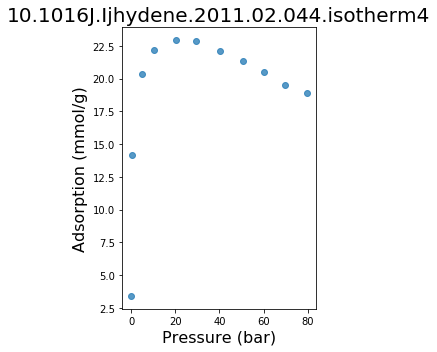

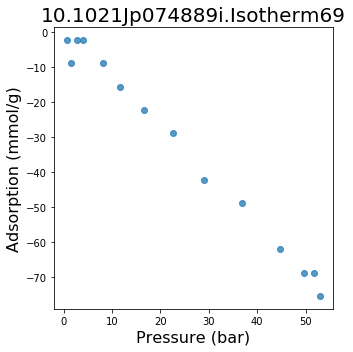

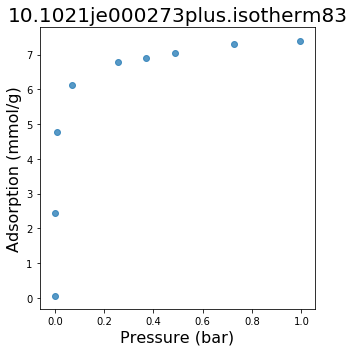

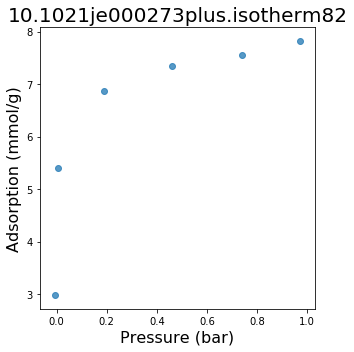

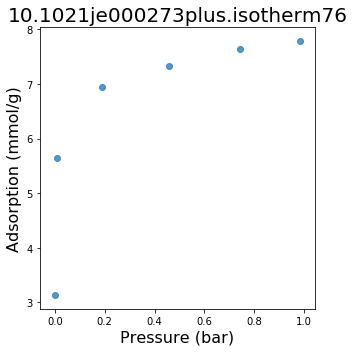

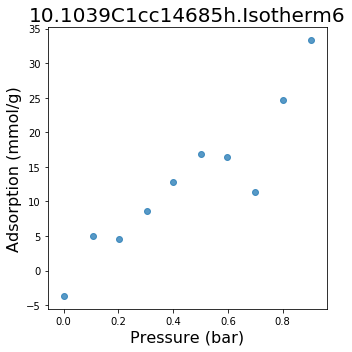

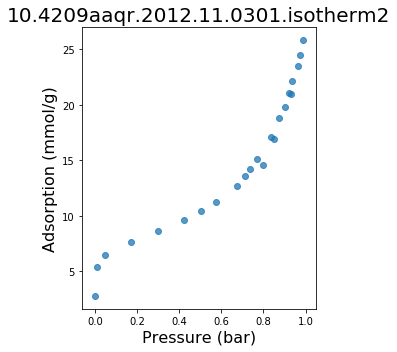

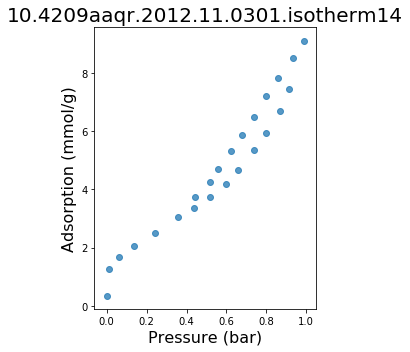

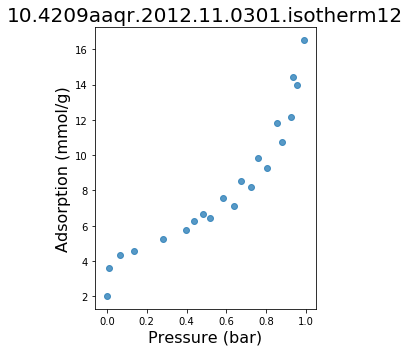

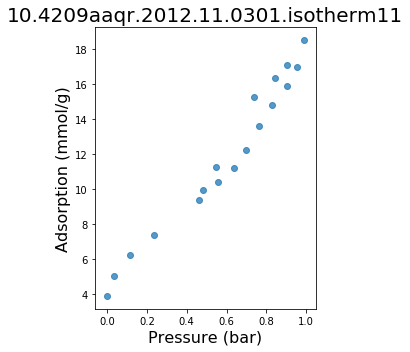

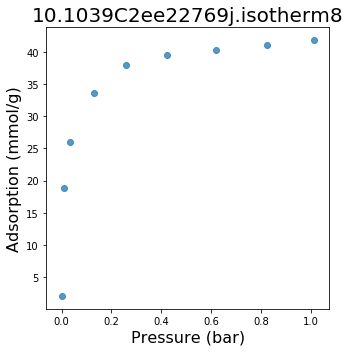

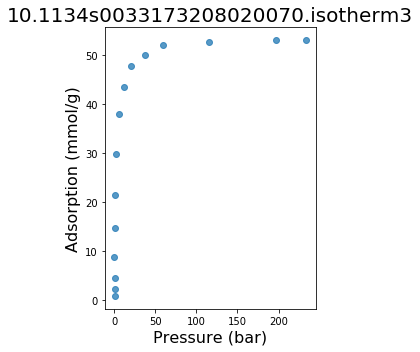

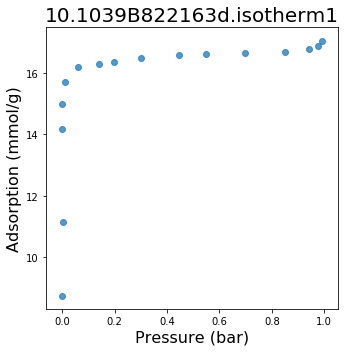

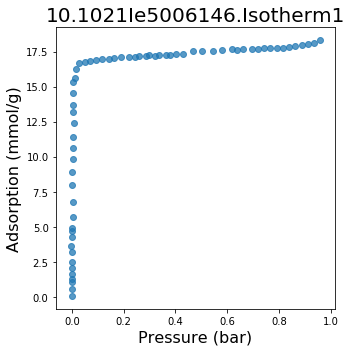

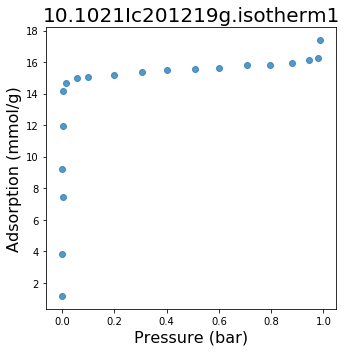

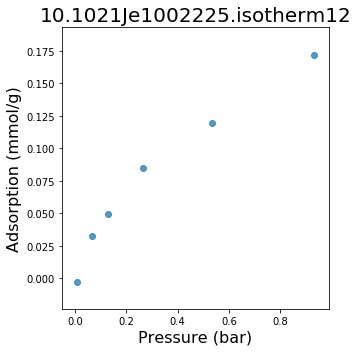

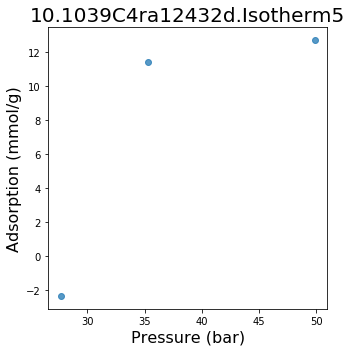

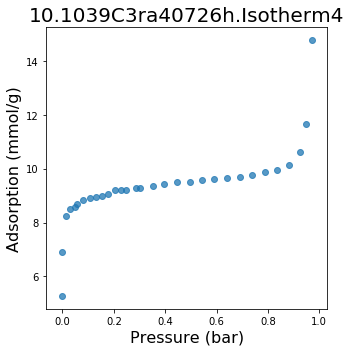

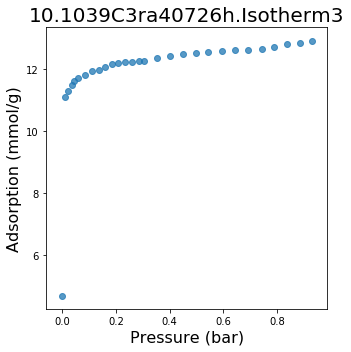

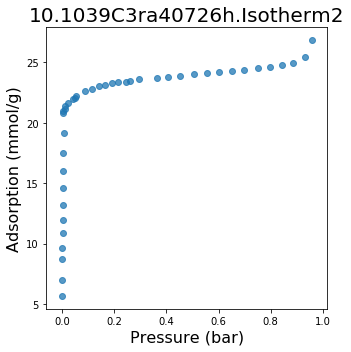

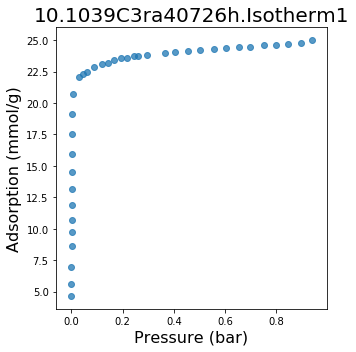

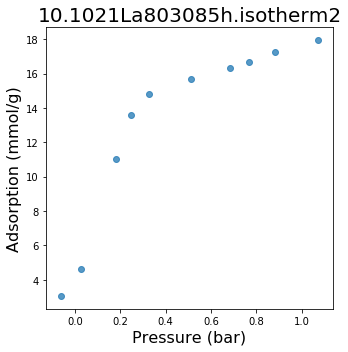

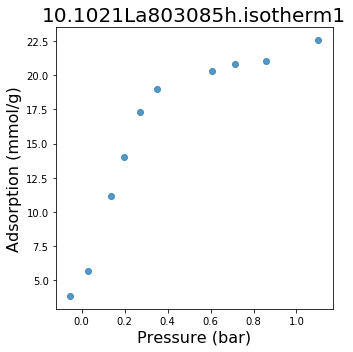

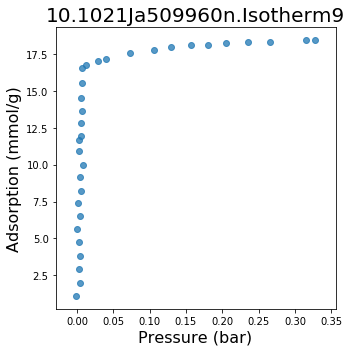

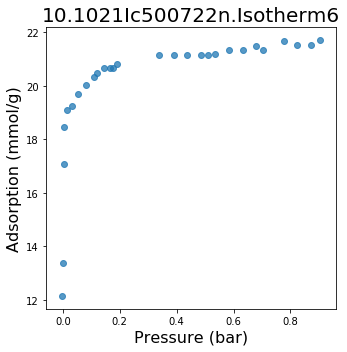

In [8]:
for messed_up_isotherm in messed_up_isotherms[:25]:
    pressure, adsorption = read_isotherm_and_convert_units(messed_up_isotherm)
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.scatter(pressure, adsorption, marker='o', alpha=0.75)
    plt.xlabel('Pressure (bar)', fontsize=16)
    plt.ylabel('Adsorption (mmol/g)', fontsize=16)
    plt.title(messed_up_isotherm, fontsize=20)
    plt.tight_layout()
    plt.show()

In [9]:
with open('messed_up_isotherms.txt', 'w') as outfile:
    for mui in messed_up_isotherms:
        outfile.write('{}\n'.format(mui))

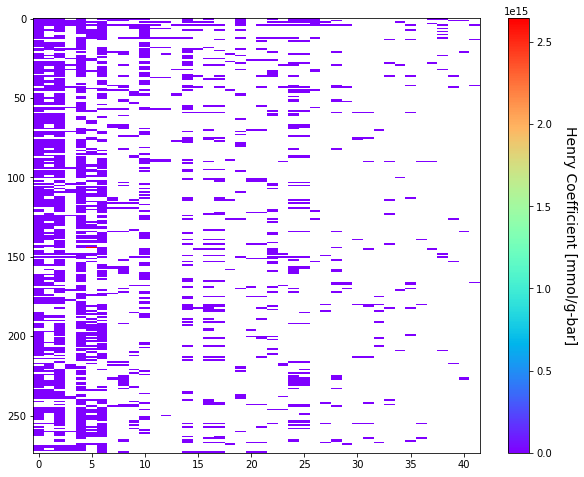

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


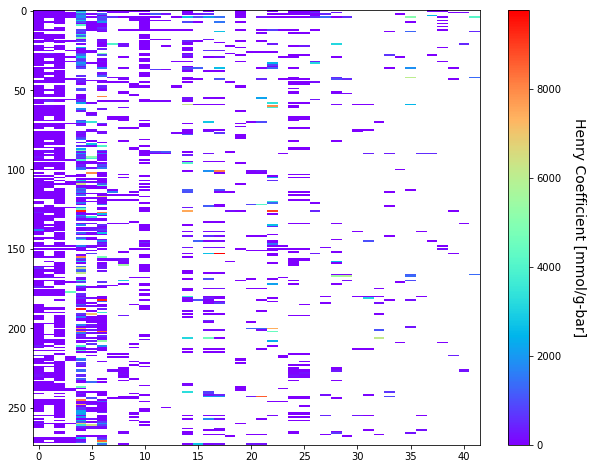

In [10]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.imshow(henry_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
ax.axis('auto')

plt.show()

mask = np.less_equal(henry_matrix, 1e4)
new_matrix = henry_matrix * mask
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.imshow(new_matrix, interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
ax.axis('auto')

plt.show()

In [11]:
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

In [12]:
henry_means = np.empty(henry_matrix.shape[1])
henry_medians = np.empty(henry_matrix.shape[1])
gas_names = np.empty(henry_matrix.shape[1], dtype=object)
henry_all_value = []
henry_all_gas = []
henry_all_mof = []
for (i, gas) in enumerate(material_gas_df.columns):
    henry_means[i] = np.nanmean(henry_matrix[:,i])
    henry_medians[i] = np.nanmedian(henry_matrix[:,i])
    gas_names[i] = key_to_gas[gas.split('_')[0]] + '_' + gas.split('_')[1]
    for (j, material) in enumerate(material_gas_df.index):
        henry_all_value.append(henry_matrix[j, i])
        henry_all_gas.append(key_to_gas[gas.split('_')[0]] + '_' + gas.split('_')[1])
        henry_all_mof.append(key_to_material[material])

henry_df1 = pd.DataFrame({'gas_name': gas_names, 'mean': henry_means, 'median': henry_medians})
henry_df2 = pd.DataFrame({'gas_name': henry_all_gas, 'mof_name': henry_all_mof, 'Henry_coeff': henry_all_value})

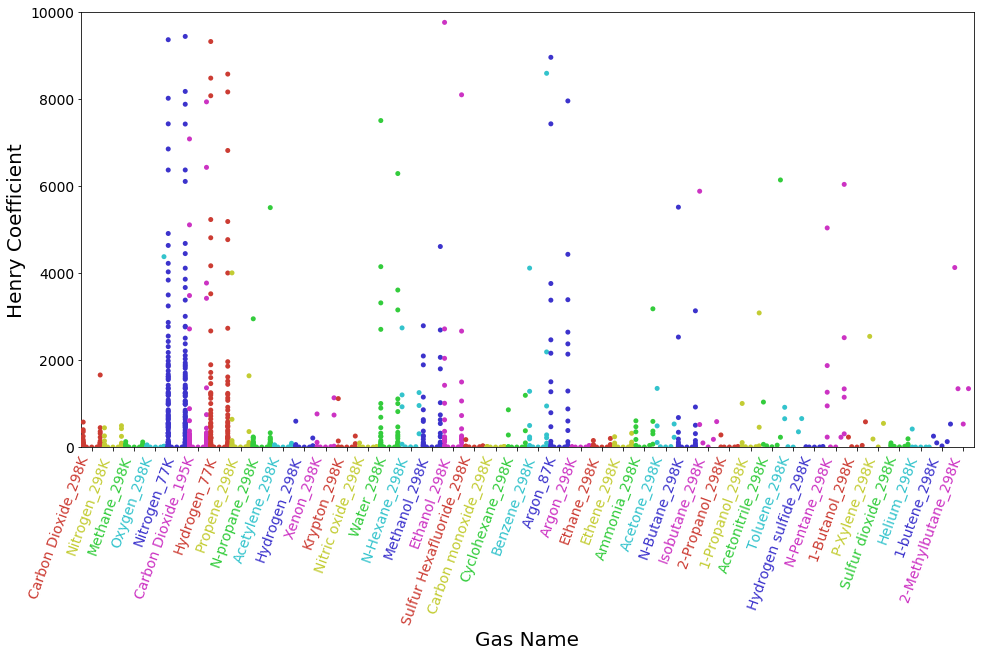

In [13]:
fig = plt.figure(figsize=(16,8))
pal = sns.hls_palette(6, l=.5, s=.6)
sp = sns.swarmplot(x='gas_name', y='Henry_coeff', hue="gas_name", palette=pal, data=henry_df2)
plt.ylim([-1, 10000])
ax = plt.gca()
ax.get_legend().remove()
plt.xticks(rotation=70, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Henry Coefficient', fontsize=20)
plt.xlabel('Gas Name', fontsize=20)
pal.as_hex()
n = len(pal)
for (i, xtick) in enumerate(ax.get_xticklabels()):
    xtick.set_color(pal[i%n])